<strong><h1>Controle de Tanque com Fuzzy</h1></strong>

Aluno: Wallace Ketler Melo de Morais

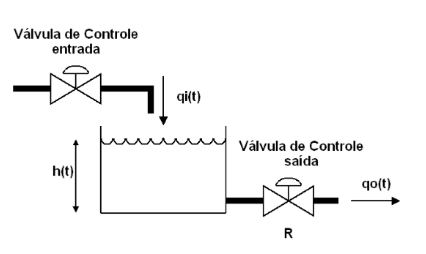

Dada a imagem acima, busca-se controlar a válvula de controle de saída do sistema, de modo que o limiar de altura pedido pelo usuários seja mantido adequadamente. Para tanto, existe uma entrada de água qi(t) e uma saída qo(t) que variam entre 0 a 15, uma altura máxima do tanque de 100cm e um limiar inserido pelo usuário entre 0 e 80 cm.

Inicialmente, é feita a instalação da biblioteca skfuzzy para que seja possibilitada a defuzzificação da saída, de modo que possamos ter um valor que represente nosso consequente. Tal valor defuzzificado, foi adotado como a representação da variação necessária para a estabilidade do sistema e não o valor exato da válvula de saída, pois assim, possibilita-se criar uma função de pertinência que represente o caso em que o erro é 0 e desejamos manter o valor atual.

In [ ]:
pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 4.5 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=e25235665764ef8c8654dc48317e1c91597abd6bec7214d45d37ffe8c282c47b
  Stored in directory: /root/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy


Subsequentemente, é feita a inclusão das bibliotecas usadas: matplotlib para que seja possível a visualização gráfica do sistema, skfuzzy para a defuzzificação, numpy para a criação de espaços lineares definidos, random para a geração de números pseudo-aleatórios, time para o caso de necessidade de simular a espera de 1 segundo para cara medição de vazão do sistema e math para cálculo de raíz quadrada. 

In [ ]:
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import numpy as np
import random
import time
import math

Além disso, foi criada a função Triângular, que possui baixo custo computacional quando comparada com as demais trapezoidal e gaussiana.

In [ ]:
def triangular(x,a,m,b):
    return max(min((x-a)/(m-a),(b-x)/(b-m)),0)

Posteriormente, é definido dois espaços lineares para plotar gráficos entre -100 e 100 e de -5 a 15 com 200 pedaços cada. Isso ocorre pois o antecedente ERRO pode variar entre -100 e 100 e o consequente VARIAÇÃO DA VÁLVULA DE SAÍDA, apesar de poder variar, ao máximo -15 e 15, com uma variação máxima de -5 ou 5 por segundo existirá mais suavidade e, portanto, maior estabilidade no sistema.

In [ ]:
x_erro = np.linspace(-100,100,200)
x_valvula = np.linspace(-5,5,200) 

São criadas as funções do antecedente de modo que são simétricas com relação ao eixo x=0, entretanto, a função de MANTER é menos larga, já que, para que o sistema mantenha o valor de saída, existe a necessidade de que o valor do erro seja praticamente zero.

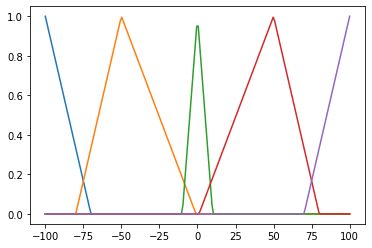

In [ ]:
erro_ng =   []
erro_np =   []
erro_nulo = []
erro_pp   = []
erro_pg   = []

for i in range(200):
  erro_ng.append(triangular(x_erro[i],-130,-100,-70))
  erro_np.append(triangular(x_erro[i],-80, -50, -1))
  erro_nulo.append(triangular(x_erro[i],-10, 0, 10))
  erro_pp.append(triangular(x_erro[i],1, 50, 80))
  erro_pg.append(triangular(x_erro[i],70, 100, 130))

plt.plot(x_erro,erro_ng)
plt.plot(x_erro,erro_np)
plt.plot(x_erro,erro_nulo)
plt.plot(x_erro,erro_pp)
plt.plot(x_erro,erro_pg)
plt.show()

No consequente, definimos quanto alterar o valor da válvula de saída, de modo que as funções criadas são simétricas em relação ao eixo x = 0.

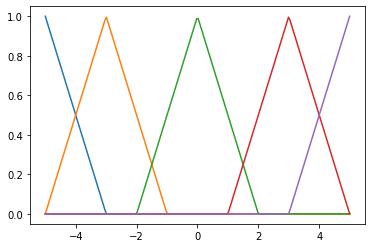

In [ ]:
fechar_muito =  []
fechar_pouco  = []
manter       =  []
abrir_pouco  =  []
abrir_muito  =  []
for i in range(200):
  fechar_muito.append(triangular(x_valvula[i],-7,-5,-3))
  fechar_pouco.append(triangular(x_valvula[i],-5,-3,-1))
  manter.append(triangular(x_valvula[i],-2,0,2))
  abrir_pouco.append(triangular(x_valvula[i],1,3,5))
  abrir_muito.append(triangular(x_valvula[i],3,5,7))
  
plt.plot(x_valvula,fechar_muito)
plt.plot(x_valvula,fechar_pouco)
plt.plot(x_valvula,manter)
plt.plot(x_valvula,abrir_pouco)
plt.plot(x_valvula,abrir_muito)
plt.show()

Para sabermos o quanto ativar das funções consequentes, devemos definir a lista de regras a serem seguidas de antecedente e consequente:<br> 
se ERRO é NEGATIVO POUCO então FECHAR POUCO<br>
se ERRO é NEGATIVO MUITO então FECHAR MUITO<br>
se ERRO é NULO então MANTER<br>
se ERRO é POSITIVO POUCO então ABRIR POUCO<br>
se ERRO é POSITIVO MUITO então ABRIR MUITO<br>

Além disso, o usuário deve definir qual o limiar ele deseja desde que seja entre 0 e 80

In [ ]:
limiar = int(input("Insira o limiar desejado: "))
if(limiar<0 or limiar>80):
  while(limiar<0 or limiar >80):
    limiar = input("Insira um limiar entre 0 e 80: ")

Insira o limiar desejado: 50


Para simular o fluxo de entrada no tanque, será gerado um número aleatório entre 10 e 15 litros, a cada segundo, mas que poderia ser entre qualquer intervalo entre 0 e 15, ou ainda, um valor fixo entre 0 e 15. para cada input de erro(criado a partir da comparação do limiar com a altura atual)será gerada uma saída defuzzificada da válvula de saída. Neste caso, o valor inicial de altura e vazão de saída assumirão valor 0. Quanto ao tempo, podemos usar a biblioteca time para pausar 1 segundo cada iteração para que simulemos de forma mais realista as alterações, entretanto, uma vez que tal decisão acarretaria em grande tempo de execução para teste das saídas, a priori tal método foi deixado comentado.

In [ ]:
altura_atual = 0  #em cm
vazao_saida = 0   #em L/s
ajustes = 0 # contador de ajustes para plotar gráfico
valoresAjustes = []

while(ajustes < 1000):
  ajustes = ajustes + 1
  valor_entrada = random.randint(10,15)
  altura_atual = altura_atual + valor_entrada
  erro_real = altura_atual - limiar
  erro = erro_real + 100

  agregacao = []
  c1 = []
  c2 = []
  c3 = []
  c4 = []
  c5 = []

  for i in range(200):
    c1.append(min(erro_nulo[erro],manter[i]))
    c2.append(min(erro_np[erro],fechar_pouco[i]))
    c3.append(min(erro_ng[erro],fechar_muito[i]))
    c4.append(min(erro_pg[erro],abrir_muito[i]))
    c5.append(min(erro_pp[erro],abrir_pouco[i]))
    agregacao.append(max(c1[i],c2[i],c3[i],c4[i],c5[i]))

  saida_defuzzy = fuzz.defuzz(np.array(x_valvula), np.array(agregacao), "centroid")

  # a vazão de saída não pode ser menor que 0 ou maior que 15
  if(vazao_saida + saida_defuzzy > 15):
    vazao_saida = 15
  elif(vazao_saida + saida_defuzzy < 0):
    vazao_saida = 0
  else:
    vazao_saida = vazao_saida + saida_defuzzy #é o tanto que ta saindo + ou - a saída defuzzy
  

  #print(len(erro_nulo))
  print("erro: " + str(erro_real))

  valoresAjustes.append(altura_atual)
  altura_atual = altura_atual - int(vazao_saida)


  #time.sleep(1)


erro: -36
erro: -21
erro: -11
erro: 1
erro: 11
erro: 21
erro: 25
erro: 27
erro: 28
erro: 28
erro: 23
erro: 21
erro: 17
erro: 15
erro: 14
erro: 14
erro: 13
erro: 8
erro: 3
erro: 2
erro: 0
erro: -4
erro: -8
erro: -9
erro: -10
erro: -5
erro: -2
erro: -1
erro: 1
erro: 7
erro: 8
erro: 9
erro: 5
erro: 3
erro: 0
erro: -2
erro: -4
erro: -4
erro: -3
erro: -3
erro: -4
erro: -7
erro: -10
erro: -7
erro: -5
erro: 1
erro: 3
erro: 7
erro: 12
erro: 12
erro: 10
erro: 9
erro: 4
erro: 4
erro: 0
erro: -3
erro: -4
erro: -3
erro: -2
erro: -3
erro: -3
erro: -2
erro: -2
erro: -1
erro: 0
erro: 0
erro: -3
erro: -6
erro: -6
erro: -7
erro: -8
erro: -3
erro: 1
erro: 5
erro: 7
erro: 10
erro: 7
erro: 7
erro: 5
erro: 3
erro: -1
erro: -6
erro: -6
erro: -6
erro: -8
erro: -6
erro: -4
erro: -1
erro: -2
erro: -2
erro: -3
erro: -4
erro: 0
erro: 3
erro: 6
erro: 10
erro: 8
erro: 6
erro: 5
erro: 3
erro: -1
erro: -3
erro: -7
erro: -9
erro: -10
erro: -9
erro: -5
erro: -3
erro: 2
erro: 4
erro: 10
erro: 12
erro: 10
erro: 9
erro: 

Dada a coleta dos dados, podemos finalmente, analisar estatisticamente os resultados:

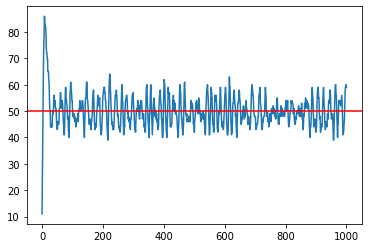

Média: 50.141
Variância amostral: 38.389508508508456
Desvio Padrão amostral: 6.195926767523036


In [ ]:
xAjustes = np.linspace(0,1000,1000)
plt.plot(xAjustes,valoresAjustes)
plt.axhline(y = limiar, color = 'r', linestyle = '-')
plt.show()

#cálculos estatísticos
soma = 0
soma_quadrada = 0
media = 0
dp = 0
variancia = 0
for i in range(1000):
  soma = valoresAjustes[i] + soma
  soma_quadrada = soma_quadrada + (valoresAjustes[i]*valoresAjustes[i])

media = soma/1000
variancia = (soma_quadrada - ((soma*soma)/1000))/(1000-1)
dp = math.sqrt(variancia)
print("Média: " + str(media))
print("Variância amostral: " + str(variancia))
print("Desvio Padrão amostral: " + str(dp))

Logo, para um teste de limiar 60, o gráfico acima descreve os valores de altura obtidos em função do tempo. Sobre eles, cabe ressaltarmos que o valor médio obtido foi satisfatório, pois atingiu o esperado, entretanto, o desvio padrão foi de aproximadamente 6, o que significa que em geral, o valores flutuaram em 6 em torno da média. Cabe complementar, ainda, que caso o limiar seja definido muito alto (próximo de 80) ou muito baixo (próximo de 0), dada a variação que ocorre em torno da altura adequada, pode ocorrer transbordamentos ou, ainda, alturas negativas por determinado período de tempo, o que pode ser tratado facilmente com lógica de programação. Sobre isso, algo semelhante foi feito em relação ao limite da vazão de saída. Isso porque a saída defuzzificada define quanto deve-se variar a válvula de saída, mas caso a vazão atual de saída seja algo próxima de 15 e a saída defuzzificada peça para aumentar mais para compensar o erro da entrada, o valor de saída será fixada em 15, que é o limite da válvula.